In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
from string import punctuation
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('Preprocess_Reviews.csv')
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,sentiment,neg,neu,pos,compound
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,5,feel lucky found used phone u used hard phone ...,1.0,positive,0.100,0.592,0.308,0.8966
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,4,nice phone nice grade pantach revue clean set ...,0.0,positive,0.155,0.445,0.400,0.8548
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,5,pleased,0.0,positive,0.000,0.000,1.000,0.4404
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,4,work good go slow sometimes good phone love,0.0,positive,0.000,0.333,0.667,0.8750
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,4,great phone replace lost phone thing volume bu...,0.0,positive,0.103,0.714,0.183,0.4215


In [3]:
#Drop unnecessary columns:
df = df.drop(['Product Name', 'Price', 'Review Votes', 'Brand Name'], axis=1)
df.dropna(inplace=True)

In [4]:
df.head()

,Rating,Reviews,sentiment,neg,neu,pos,compound
0,5,feel lucky found used phone u used hard phone ...,positive,0.100,0.592,0.308,0.8966
1,4,nice phone nice grade pantach revue clean set ...,positive,0.155,0.445,0.400,0.8548
2,5,pleased,positive,0.000,0.000,1.000,0.4404
3,4,work good go slow sometimes good phone love,positive,0.000,0.333,0.667,0.8750
4,4,great phone replace lost phone thing volume bu...,positive,0.103,0.714,0.183,0.4215


<Axes: xlabel='Rating', ylabel='count'>

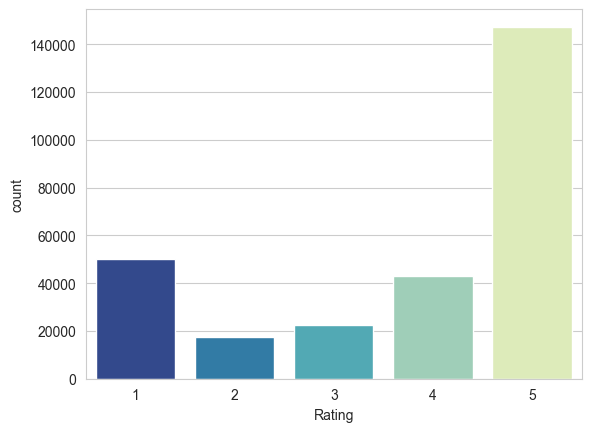

In [5]:
sns.set_style('whitegrid')
sns.countplot(x='Rating',data=df, palette='YlGnBu_r')

<Axes: xlabel='sentiment', ylabel='count'>

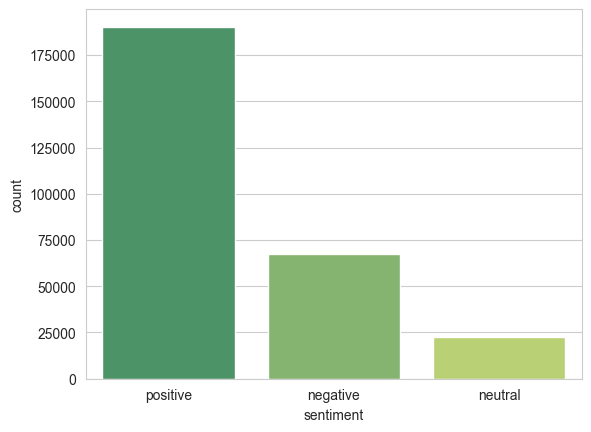

In [6]:
sns.set_style('whitegrid')
sns.countplot(x='sentiment',data=df, palette='summer')

In [7]:
print(df[df['sentiment'] == 'positive'].shape)
print(df[df['sentiment'] == 'negative'].shape)
print(df[df['sentiment'] == 'neutral'].shape)

(190339, 7)
(67557, 7)
(22605, 7)


# Data Pre-processing

In [8]:
df_Positive = df[df['sentiment'] == 'positive'][0:20000]
df_Neutral = df[df['sentiment'] == 'neutral']
df_Negative = df[df['sentiment'] == 'negative']

### Sample negative and neutral dataset and create a final dataset:

In [9]:
df_Neutral_over = df_Neutral.sample(20000, replace=True)
df_Negative_over = df_Negative.sample(20000, replace=True)
df = pd.concat([df_Positive, df_Neutral_over, df_Negative_over], axis=0)

In [10]:
df

,Rating,Reviews,sentiment,neg,neu,pos,compound
0,5,feel lucky found used phone u used hard phone ...,positive,0.100,0.592,0.308,0.8966
1,4,nice phone nice grade pantach revue clean set ...,positive,0.155,0.445,0.400,0.8548
2,5,pleased,positive,0.000,0.000,1.000,0.4404
3,4,work good go slow sometimes good phone love,positive,0.000,0.333,0.667,0.8750
4,4,great phone replace lost phone thing volume bu...,positive,0.103,0.714,0.183,0.4215
...,...,...,...,...,...,...,...
271878,1,good product never gon na battery dont work tr...,negative,0.000,0.536,0.464,0.7115
70937,1,excelente,negative,0.000,1.000,0.000,0.0000
273757,1,look neat slow hard time getting set straight ...,negative,0.046,0.523,0.431,0.8957
87690,1,phone worst thing ever ive bit year far past m...,negative,0.162,0.738,0.099,-0.7749


In [11]:
df.shape

(60000, 7)

In [12]:
# One-hot encode the sentiment labels
one_hot = pd.get_dummies(df["sentiment"])
df.drop(["sentiment"], axis=1, inplace=True)
df = pd.concat([df, one_hot], axis=1)

In [13]:
# Verify the shape of one-hot encoded labels
print("One-hot encoded labels shape:", one_hot.shape)

One-hot encoded labels shape: (60000, 3)


In [14]:
# Prepare features and labels
X = df["Reviews"].values
y = one_hot.values  # Ensure y is derived from one-hot encoding
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [15]:
# Tokenize and pad the sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [16]:
# Get the maximum sequence length
max_sequence_len = 100

In [17]:
vocab_size = len(tokenizer.word_index) + 1

In [18]:
# Pad sequences
X_train = pad_sequences(X_train, maxlen=max_sequence_len)
X_test = pad_sequences(X_test, maxlen=max_sequence_len)

In [19]:
# Build the RNN model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_sequence_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=y_train.shape[1], activation='softmax'))

C:\Users\MK Jutt\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [20]:
# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [21]:
# Define early stopping
early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=2)

In [22]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=128,
    epochs=10,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 95s 277ms/step - accuracy: 0.5914 - loss: 0.8452 - val_accuracy: 0.7654 - val_loss: 0.5613
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 91s 277ms/step - accuracy: 0.7795 - loss: 0.5349 - val_accuracy: 0.7872 - val_loss: 0.5293
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 91s 276ms/step - accuracy: 0.8137 - loss: 0.4703 - val_accuracy: 0.7939 - val_loss: 0.5170
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 60s 182ms/step - accuracy: 0.8298 - loss: 0.4320 - val_accuracy: 0.8010 - val_loss: 0.5077
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 64s 195ms/step - accuracy: 0.8389 - loss: 0.4206 - val_accuracy: 0.8067 - val_loss: 0.5114
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 66s 200ms/step - accuracy: 0.8519 - loss: 0.3883 - val_accuracy: 0.8101 - val_loss: 0.5099
Epoch 6: early stopping


In [23]:
# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

563/563 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.8101 - loss: 0.5080
Validation Loss: 0.5099
Validation Accuracy: 0.8101


In [24]:

# Plot training history
def plot_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

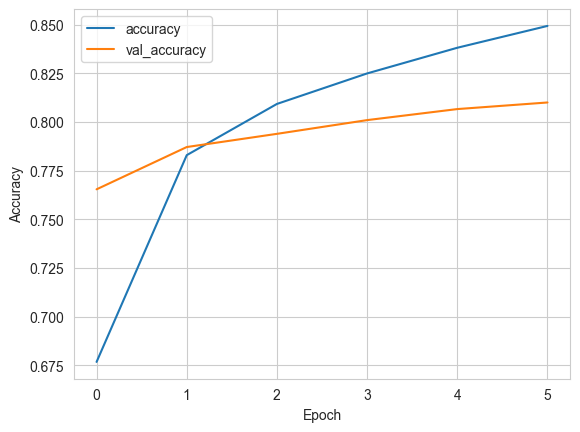

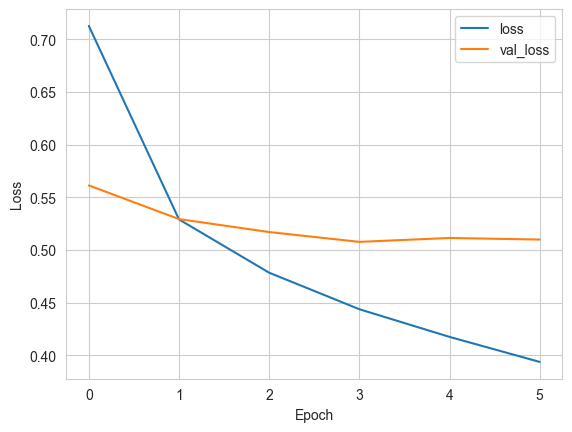

In [25]:
# Plot accuracy and loss
plot_history(history)

In [26]:
import joblib
# Save the best model to a file
joblib_file = "RNN_model.joblib"
joblib.dump(model, joblib_file)
print(f"Model saved to {joblib_file}")

Model saved to RNN_model.joblib


In [36]:
# Load the model from the file
loaded_model = joblib.load("RNN_model.joblib")
print("Model loaded successfully")

Model loaded successfully


In [37]:
# Example new reviews
new_reviews = ["My phone not working well", "I appreciate that company to providing good product."]


In [38]:
# Tokenize and pad the new reviews
new_reviews_seq = tokenizer.texts_to_sequences(new_reviews)
new_reviews_pad = pad_sequences(new_reviews_seq, maxlen=max_sequence_len)

In [39]:
# Ensure the shape is compatible with the model input
print(new_reviews_pad.shape)  # Should be (2, max_sequence_len)

(2, 100)


In [43]:
# Debugging print statements
print("Predictions (raw):")
print(preds)

Predictions (raw):
[[0.28250042 0.20389475 0.5136048 ]
 [0.03616129 0.14833371 0.8155051 ]]
